### An example how to use explainable AI for management accounting research


Information in the following code is color-coded to make it easier to find parts relevant for the discussion of the accompanying article.

<div class="alert-warning">
Yellow is used for parts of the code which are irrelevant and perform, for example, pre-processing operations.
</div>

<div class="alert-info">
Blue is used for the relevant parts of the code.
</div>

----------------

<div class="alert-warning">
Libraries
</div>

* Pandas for data handling
* XGBoost for creating the boosting model
* Numpy is needed in a few places to calculate mean value, absolute value, etc. for values in tables
* SHAP includes the tools for explainable AI
* Matplotlib for plotting
* Boosting_library_mra includes special functions for the process. The details are explained in the library.

In [ ]:
import pandas as pd
import xgboost as xgb
import numpy as np
import shap
import matplotlib.pyplot as plt

import boosting_library as bl

<div class="alert-warning">
Preprocessing
</div>

* Load the data to a Pandas dataframe. **NOTE! Due to copyrgiht issues, this data is randomized and cannot be used for research. Therefore, the results in this example are slightly different from the results in the accompanying artcile, which uses the real data.**
* Shift the values of Patent filings so that is easier to predict t+1 values using the t+0 values of other variables.
* Create R&D missing -variable that has value 1 if R&D intensity is missing for that observation.
* Creat Sales growth -variable
* Use only observations between the years 2014-2019
* Use the prepare_data -function of the accompanying library. The details of the function are explained in the library.
* Winsorize the control variables
* Create more informative names for the variables
* Create 2-digit SIC categories
* Create more informative names for the employee opinion variables. Notice that many of them are not used in this example.
* Create a dummy variable that gets value 1 if Board gender diversity for that observation is larger than zero
* Add the predicted variable to the y_df Pandas series
* Create a list including the names of the diversity variables included in the model
* Create a list includding the names of all the predictors
* Create a x_df Pandas dataframe including all the predictors

In [2]:
full_table_df = pd.read_csv('randomized_data.csv',index_col=0)

In [4]:
full_table_df['corrected_filings'] = full_table_df.groupby(['conm']).shift(-1)['corrected_filings']

full_table_df['R&D missing'] = full_table_df['rd_int'].isna()

full_table_df['Sales growth'] = full_table_df.groupby('conm')['sale'].pct_change()

full_table_df = full_table_df[(full_table_df['fyear'] > 2013) & (full_table_df['fyear'] <= 2019)]

full_table_df = bl.prepare_data(full_table_df,'corrected_filings')

win_contr_df = bl.winsorize_data(full_table_df[['at','cap_int','lvg','rd_int','roa','optvol','tobin',
                                                'Sales growth','corrected_filings']])

full_table_df['Total assets (1000$)'] = win_contr_df['at']
full_table_df['Capital intensity'] = win_contr_df['cap_int']
full_table_df['Leverage'] = win_contr_df['lvg']
full_table_df['R&D intensity'] = win_contr_df['rd_int']
full_table_df['ROA'] = win_contr_df['roa']
full_table_df['Implied volatility'] = win_contr_df['optvol']
full_table_df['Tobin\'s Q'] = win_contr_df['tobin']
full_table_df['Sales growth'] = win_contr_df['Sales growth']
full_table_df['Patent filings (t+1)'] = win_contr_df['corrected_filings']

full_table_df.rename({'age':'Firm age'},axis=1,inplace=True)

temp = full_table_df['sic'].values/100
sic1dig = [int(i) for i in np.floor(temp)]
full_table_df['SIC 2-digit'] = sic1dig

full_table_df.rename(columns = {'Internal Communication':'Internal communication','fyear':'Fiscal year'},inplace = True)

y_df = full_table_df['Patent filings (t+1)']

intrest_vars = ['Internal communication', 'Support from management','Freedom to work independently','Overall compensation for your work']

x_vars = intrest_vars + ['Total assets (1000$)','Capital intensity','Tobin\'s Q',
                  'Leverage', 'R&D intensity','ROA', 'Implied volatility','Firm age',
                  'Sales growth', 'SIC 2-digit','Fiscal year']

x_df = full_table_df[x_vars]

<div class="alert-info">
XGBoost model
</div>

* Create an efficient Dmatrix datatype included in the XGBoost library. Using DMatrix datatype speeds up calculations significantly.
* Define the optimal parameters for the XGBoost model. In the same order: depth of trees, the weight for the following tree, the percentage size of a subsample used for one tree, the percentage of predictors used for one tree, the minimum number of observation in the leaves of the decision trees, the minimum reguired decrease of the loss function for each branch, the type of the loss function
* XGBoost cv -function can be used to search the optimal number of trees with 5-fold cross-validation. As we can see from the figure, the validation set loss decreases until we have approximately 400 trees in our boosting model. The number of trees used in this example is 600.
* XGBoost train -function is used to train the boosting model
* XGBoost plot_importance -function can be used to evaluate the importance of predictors. The function incorporates simple importance metrics, like the weight metric

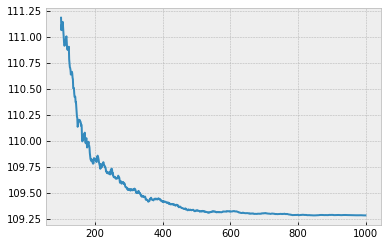

In [5]:
dtrain = xgb.DMatrix(x_df, label=y_df, nthread = -1)

param = {'max_depth': 4, 'eta': 0.2, 'subsample': 0.8,
         'colsample_bytree': 0.6, 'min_child_weight' : 1, 'gamma' : 0.,'objective' : 'reg:squarederror'}

temp = xgb.cv(param,dtrain,num_boost_round=1000,nfold=5,seed=10)

plt.plot(temp['test-rmse-mean'][100:1000])
plt.show()

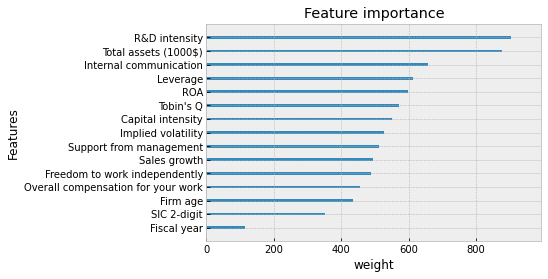

In [6]:
b_rounds = 600

bst = xgb.train(param,dtrain,num_boost_round=b_rounds)

plt.Figure(figsize=(20,20))
xgb.plot_importance(bst,importance_type='weight',show_values=False,xlabel='weight')
plt.show()

<div class="alert-info">
Incorporating SHAP and SAGE for more detailed analysis
</div>

* The calculate_bootstrap -function of the specific library is used to create bootstrap samples from XGBoost models, and to calculate the SHAP values for each model. The details of the function are explained in the library
* The plot_bootstrap_shaps -function is used to plot the average and confidence intervals of using the bootstrap samples. The details are in the library.

In [ ]:
bootstrap_samples_df, bootstrap_shaps_df = bl.calculate_bootstrap(full_table_df,x_df.columns,'Patent filings (t+1)',param,'GVKEY',n_values=len(y_df),
                                                                  metrics='mae',num_trees=b_rounds,boot_rounds=50,esr=50)

#### Part 1

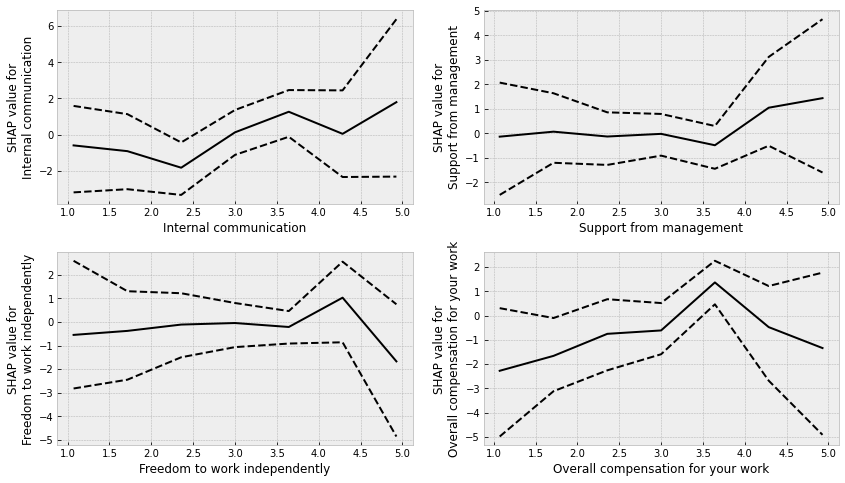

In [11]:
bl.plot_bootstrarp_shaps(bootstrap_samples_df,bootstrap_shaps_df,x_vars=intrest_vars,nobs=len(y_df),no_bins=8,plot_arr=[2,2],name_prefix = 'EAR_experiment1',
                         figsize=(14,8), alpha=0.05, y_limits=False,c_limit=0.15,c_bool=True,hspace=0.25,show_obs=False)

<div class="alert-info">
Direct SHAP calculations
</div>

* The initjs -function is used to initilize the SHAP model
* Explainer() is used to calculate the SHAP explainer object
* plots.waterfall() is used to create a waterfall plot for an individual observation
* summary_plot() with plot_type=bar can be used to rank the importance of predictors. It calculates mean(abs(SHAP)) from individual observations

In [7]:
j=0
shap.initjs()

In [8]:
explainer = shap.TreeExplainer(bst, x_df)

In [9]:
shap_values = explainer(x_df)

 98%|===================| 2152/2196 [00:23<00:00]        

In [10]:
full_table_df.iloc[45]

corrected_filings                     184.520091
conm                                   ADOBE INC
GVKEY                                      12540
sic                                         7370
rd_int                                  0.078284
sale                                    4147.065
Fiscal year                                 2014
at                                     10785.829
cap_int                                 0.013752
lvg                                     0.223485
rd_int.1                                0.078284
roa                                     0.024884
optvol                                       NaN
tobin                                   3.724981
Firm age                                     336
Internal communication                       5.0
Support from management                      5.0
Freedom to work independently                5.0
Overall compensation for your work           5.0
R&D missing                                False
Sales growth        

#### Part 2 

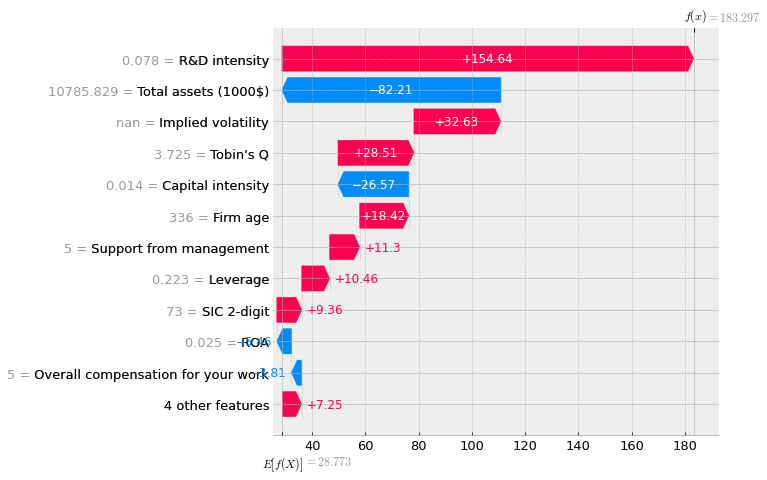

In [11]:
shap.plots.waterfall(shap_values[45],show=True,max_display=12)

#### Part 3

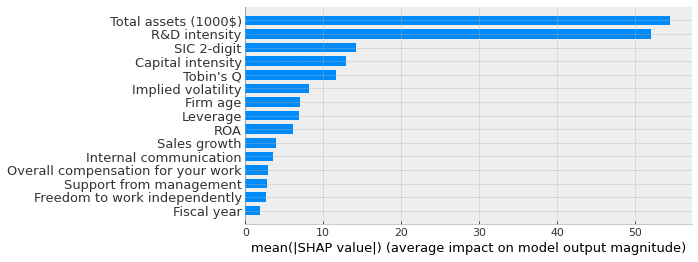

In [12]:
shap.summary_plot(shap_values,x_df,plot_type='bar',max_display=15,plot_size=(8,4),show=False)

<div class="alert-info">
Calculate SHAPs two-wise interactions
</div>

* Create explainer object
* Calculate two-wise interaction values
* Numpy mean()- and abs()-functions are used to calculate mean(abs()) of the interaction SHAP values
* Pandas Dataframe() -function is used to create a table of two-wise importances.
* The following steps are used to create the bar chart below, where the two-wise interaction importances of the diversity variables are plotted.
* Summary_plot() with plot_type='compact_dot' can be used to analyze in detail the interaction SHAP values
* Dependence_plot() can be used to analyze how one predictor (R&D intensity in this example) affects the output, but also the predictors interaction with another predictor (Total assets in this case).

In [13]:
explainerXGB = shap.TreeExplainer(bst)

In [14]:
shap_normal = explainerXGB.shap_values(x_df,y_df)

In [15]:
shap_interactions_np = explainerXGB.shap_interaction_values(x_df,y_df)

In [16]:
abs_mean_np = np.mean(np.abs(shap_interactions_np),axis=0)

In [17]:
inter_df = pd.DataFrame(index=x_df.columns, columns=x_df.columns,data=abs_mean_np)

In [18]:
inter_df

,Internal communication,Support from management,Freedom to work independently,Overall compensation for your work,Total assets (1000$),Capital intensity,Tobin's Q,Leverage,R&D intensity,ROA,Implied volatility,Firm age,Sales growth,SIC 2-digit,Fiscal year
Internal communication,2.369603,0.331417,0.391438,0.395019,0.673750,1.198540,0.959477,0.454823,1.096681,0.475956,0.827311,0.372886,0.376135,0.440975,0.188844
Support from management,0.331418,1.804240,0.484674,0.347049,0.488275,0.190780,0.397406,0.432949,1.039923,0.501889,0.492963,0.259315,0.240843,0.336185,0.197812
Freedom to work independently,0.391438,0.484674,1.670008,0.241193,0.692257,0.287205,0.194809,0.411478,0.749864,0.729126,0.327058,0.251340,0.238122,0.339517,0.057013
Overall compensation for your work,0.395019,0.347049,0.241193,1.880829,0.473547,0.226980,0.460595,0.509574,0.733412,0.230817,0.238541,0.395420,0.239946,0.739833,0.550573
Total assets (1000$),0.673750,0.488277,0.692256,0.473548,51.793941,5.827564,4.752573,2.619096,24.898617,3.035129,3.851501,1.338838,1.866439,3.520404,0.834792
Capital intensity,1.198541,0.190781,0.287205,0.226980,5.827567,14.074244,1.559839,0.509681,5.355683,0.396361,1.797357,1.100319,0.490464,0.501413,0.084476
Tobin's Q,0.959477,0.397406,0.194809,0.460595,4.752573,1.559837,9.207519,0.729100,2.643972,1.006409,2.125252,0.392133,0.642441,1.052647,0.527303
Leverage,0.454823,0.432949,0.411478,0.509574,2.619096,0.509681,0.729101,6.449233,3.345912,0.766440,0.666275,0.325605,0.398649,1.261461,0.090777
R&D intensity,1.096681,1.039924,0.749864,0.733413,24.898617,5.355686,2.643972,3.345912,64.504234,1.997724,4.701380,5.842272,2.190984,8.110107,0.490972
ROA,0.475956,0.501889,0.729126,0.230817,3.035126,0.396360,1.006408,0.766439,1.997725,7.465135,0.550896,0.613313,0.720779,1.160820,0.353224


In [19]:
var_names = []
interaction_importance = []
i=0
for name1 in x_df.iloc[:,0:4].columns:
    j=i+0
    for name2 in x_df.iloc[:,0:4].columns[i:]:
        var_names.append(name1 + ' * ' + name2)
        interaction_importance.append(inter_df.iloc[i,j])
        j+=1
    i+=1

In [20]:
inter_ranking_df = pd.DataFrame(index=var_names,data=interaction_importance,columns=['Mean of absolute shap values'])

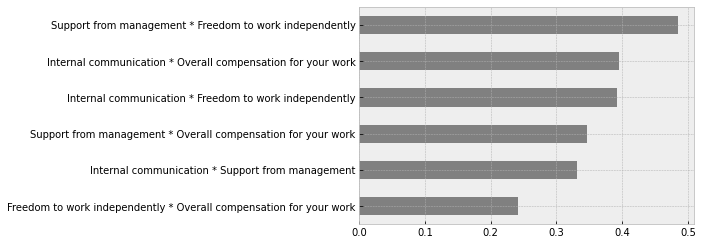

In [21]:
inter_ranking_df.sort_values('Mean of absolute shap values',ascending = True).iloc[:-4].plot.barh(legend=False,color='gray')
plt.show()

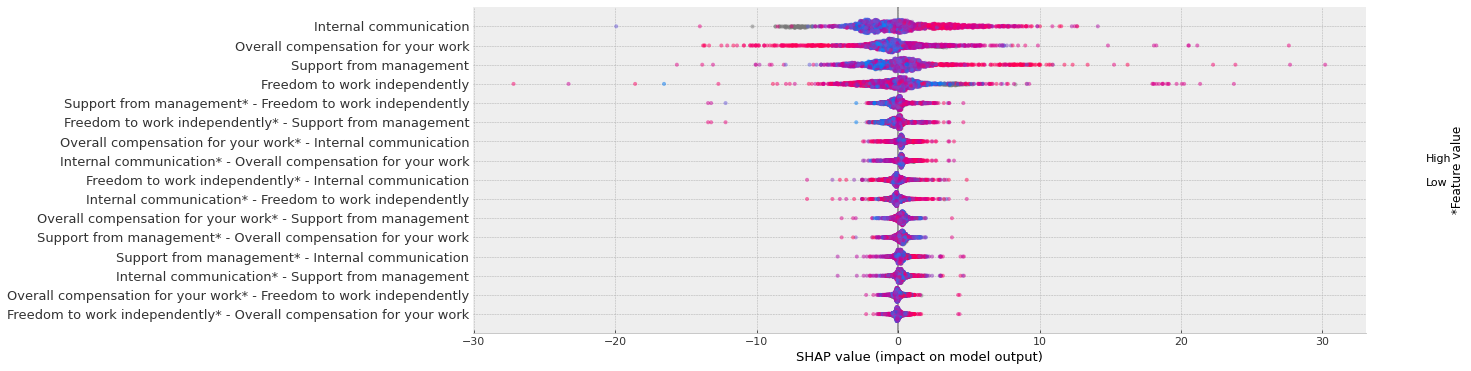

In [22]:
shap.summary_plot(shap_interactions_np[:,0:4,0:4],x_df.iloc[:,0:4],max_display = 60,plot_type='compact_dot',
                  sort=True,plot_size=(20,6),alpha=0.5,cmap=plt.get_cmap('Greys'))

#### Part 4

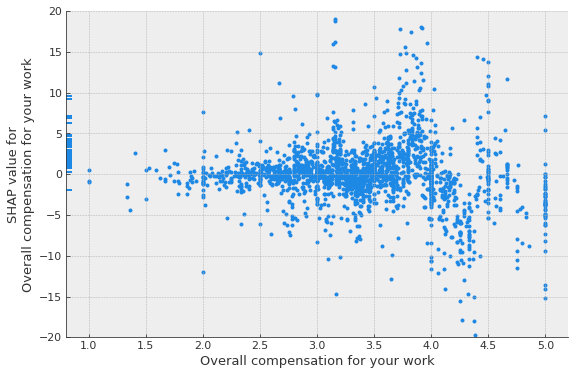

In [29]:
fig,ax = plt.subplots(figsize=(9,6))
ax.set_ylim(-20,20)
shap.dependence_plot('Overall compensation for your work',shap_normal,x_df,ax=ax,interaction_index=None)

<div class="alert-info">
An example of using SHAP values to analyze the effect of the diversity variables for two subgroups of comapnies
</div>

* For easier manipulation, the SHAP values are saved into Pandas dataframe
* In this example, we use Lowess curves to approximate the trends in SHAP values. The Statsmodels -library includes these curves.
* Separate graphs for the different diversity dimensions. And different colors for the cases BGD=0 and BGD>0

In [29]:
shap_df = pd.DataFrame(shap_normal,columns=x_df.columns)

In [30]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

In [31]:
x_df['BGD_dummy'] = x_df['R&D intensity'] > x_df['R&D intensity'].median()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### Part 5:

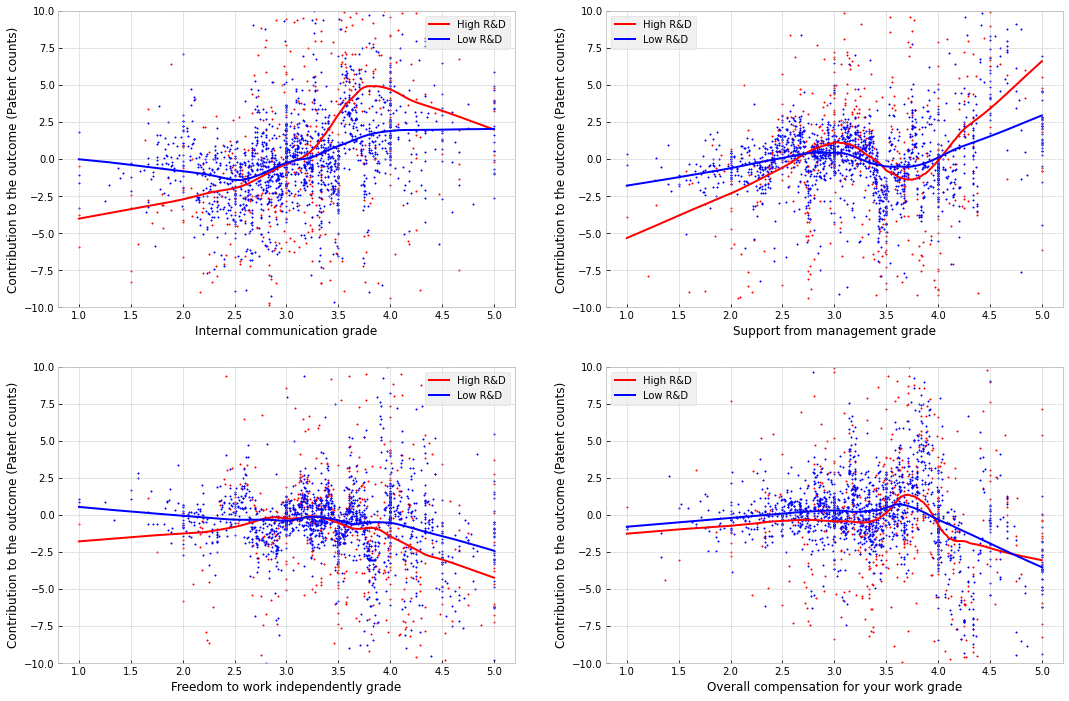

In [32]:
fig, axs = plt.subplots(2,2,figsize=(18,12),squeeze=True)

for varre,ax in zip(['Internal communication', 'Support from management','Freedom to work independently','Overall compensation for your work'],axs.flat):
    z1 = lowess(shap_df[varre][x_df['BGD_dummy']==True], x_df[varre][x_df['BGD_dummy']==True],frac=0.5)
    z2 = lowess(shap_df[varre][x_df['BGD_dummy']==False], x_df[varre][x_df['BGD_dummy']==False],frac=0.5)
    
    ax.plot(z1[:,0],z1[:,1],c='red',label = 'High R&D',linewidth=2)
    ax.plot(z2[:,0],z2[:,1],c='blue', label = 'Low R&D',linewidth=2)
    ax.scatter(x_df[varre][x_df['BGD_dummy']==True],shap_df[varre][x_df['BGD_dummy']==True],s=2,c='red')
    ax.scatter(x_df[varre][x_df['BGD_dummy']==False],shap_df[varre][x_df['BGD_dummy']==False],s=2,c='blue')
    ax.set_ylim(-10,10)
    ax.set_facecolor('white')
    ax.set_xlabel(varre + ' grade')
    ax.set_ylabel('Contribution to the outcome (Patent counts)')
    ax.legend()
#plt.ylabel('Effect of x to the prediction (Patent counts)')
plt.savefig('EAR_experiment1',dpi=300)
plt.show()

<div class="alert-info">
An example of using SAGE to estimate the global importance of variables
</div>

<div class="alert-warning">
Calculating XGBoost model
</div>

* The following steps just build the xgboost model again. This part is redundant.

In [ ]:
import sage

In [ ]:
sample_df = full_table_df

In [ ]:
y_df = sample_df['Patent filings (t+1)']

In [ ]:
x_df = sample_df[x_vars]

In [ ]:
x_df.drop('BGD_dummy',axis=1,inplace=True)

In [ ]:
dtrain = xgb.DMatrix(x_df.values, label=y_df.values, nthread = 1)

In [ ]:
m_depth = 5
eta = 0.2
ssample = 0.8
col_tree = 0.6
m_child_w = 1
gam = 0.
objective = 'reg:squarederror'
param = {'max_depth': m_depth, 'eta': eta, 'subsample': ssample,
         'colsample_bytree': col_tree, 'min_child_weight' : m_child_w, 'gamma' : gam,'objective' : objective}

In [ ]:
temp = xgb.cv(param,dtrain,num_boost_round=1500,nfold=5,seed=10)

In [ ]:
plt.plot(temp['test-rmse-mean'][150:1500])

In [ ]:
b_rounds = 600

In [ ]:
bst = xgb.train(param,dtrain,num_boost_round=b_rounds)

<div class="alert-info">
Steps to calculate the SAGE importance values
</div>

* Calculating SAGE values is very slow, so it is recommended to use only part of the data as background samples
* Once the values have been calculated, they can be plotted using the plot()-method of the sage_values -object.

In [ ]:
imputer = sage.MarginalImputer(bst,x_df.values)

In [ ]:
sampler = sage.PermutationEstimator(imputer, loss='mse')

In [ ]:
sage_values = sampler(x_df.values,y_df.values,bar=True)

In [ ]:
sage_values.plot(x_df.columns,figsize=(8,5))
plt.savefig('sage_test.png',dpi=300)